### 데이터 구성 <br>
#### data_raw 폴더 아래에
- {name}_OHLCV.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 일별 데이터
- 첫 행 : Date, Close, High, Low, Open, Volume, Ticker
- 둘째 행 : , GLD, GLD, GLD, GLD, GLD

#### monthly_return 폴더 아래에
- {name}_monthly_return.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 월별 리턴 (월간 수익률) 데이터
- 첫 행 : Date, Monthly Return

#### data_monthly 폴더 아래에
- {name}_monthly.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 월별 가격 (월간 종가) 데이터
- 첫 행 : Date, Monthly Close

#### dividend_data 폴더 아래에
- {name}_dividends.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT 존재 (GLD는 없음)
- 배당 데이터
- 첫 행 : Date, Dividend

#### total_return 폴더 아래에
- {name}_total_return.csv
- {name} : JEPI, QQQ, SCHD, SPY, TLT, GLD
- 배당 재투자 반영한 누적 수익률 데이터
- 첫 행 : Date, Monthly Return, Monthly Close, Dividend Yield, Total Return, Cumulative Return

# 1. 데이터 로딩 및 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os

# seaborn 스타일 설정
sns.set_style('whitegrid')
sns.set_context('talk')

# 종목 리스트
tickers = ['JEPI', 'QQQ', 'SCHD', 'SPY', 'TLT', 'GLD']

# 폴더 경로
data_raw_path = './data_raw'
monthly_return_path = './monthly_return'
data_monthly_path = './data_monthly'
dividend_data_path = './dividend_data'
total_return_path = './total_return'

# 1) 일별 OHLCV 데이터 읽기
ohlcv_dfs = {}
for t in tickers:
    file = os.path.join(data_raw_path, f"{t}_OHLCV.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    ohlcv_dfs[t] = df

# 2) 월별 가격(종가) 데이터 읽기
monthly_close_dfs = {}
for t in tickers:
    file = os.path.join(data_monthly_path, f"{t}_monthly.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    monthly_close_dfs[t] = df

# 3) 월별 수익률 데이터 읽기
monthly_return_dfs = {}
for t in tickers:
    file = os.path.join(monthly_return_path, f"{t}_monthly_return.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    monthly_return_dfs[t] = df

# 4) 배당 데이터 (GLD 없음)
dividend_dfs = {}
for t in ['JEPI', 'QQQ', 'SCHD', 'SPY', 'TLT']:
    file = os.path.join(dividend_data_path, f"{t}_dividends.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    dividend_dfs[t] = df

# 5) 배당 재투자 누적 수익률 데이터
total_return_dfs = {}
for t in tickers:
    file = os.path.join(total_return_path, f"{t}_total_return.csv")
    df = pd.read_csv(file, parse_dates=['Date'])
    df.set_index('Date', inplace=True)
    total_return_dfs[t] = df

# 2. 포트폴리오 구성 및 계산

In [2]:
# 포트폴리오 가중치 (월별 수익률 기준)
portfolios = {
    'Stable': {'SPY': 0, 'SCHD': 0.28, 'QQQ': 0.12, 'TLT': 0.25, 'GLD': 0.35},
    'Aggressive': {'SPY': 0.4, 'SCHD': 0.25, 'QQQ': 0.25, 'TLT': 0.05, 'GLD': 0.05}
}

# 개별 종목 : SPY, SCHD, QQQ, TLT, GLD, JEPI
# 혼합 종목들은 가중 수익률 계산용 이름
mixed_tickers = {
    'SCHD7_QQQ3': {'SCHD':0.7, 'QQQ':0.3},
    'SCHD5_QQQ5': {'SCHD':0.5, 'QQQ':0.5},
    'SPY6_TLT4': {'SPY':0.6, 'TLT':0.4},
    'SPY9_TLT1': {'SPY':0.9, 'TLT':0.1},
    'SPY5_GLD4': {'SPY':0.5, 'GLD':0.5},
    'SPY9_GLD1': {'SPY':0.9, 'GLD':0.1}
}

In [3]:
# 모든 분석할 종목 리스트 (개별 + 혼합)
all_tickers = tickers + list(mixed_tickers.keys())

# 월별 수익률 데이터로 포트폴리오 및 혼합 종목 수익률 계산
def calc_mixed_monthly_return(weights_dict, monthly_return_dfs):
    # 날짜 기준 통합 인덱스 생성
    date_index = monthly_return_dfs['SPY'].index

    # 가중 평균 수익률 계산용 DataFrame
    df = pd.DataFrame(index=date_index)

    for name, weights in weights_dict.items():
        # 종목별 월별 수익률을 가져와서 가중평균 계산
        ret = pd.Series(0, index=date_index, dtype=float)
        for t, w in weights.items():
            ret += monthly_return_dfs[t]['Monthly Return'] * w
        df[name] = ret

    return df

# 혼합 종목 월별 수익률 계산
mixed_returns_df = calc_mixed_monthly_return(mixed_tickers, monthly_return_dfs)

# 개별 종목 월별 수익률 합치기
indiv_returns_df = pd.DataFrame({t: monthly_return_dfs[t]['Monthly Return'] for t in tickers})

# 전체 종목(개별+혼합) 월별 수익률 데이터프레임
all_returns_df = pd.concat([indiv_returns_df, mixed_returns_df], axis=1)

# 3. 그래프 그리기 : 선 그래프

## 3-1. 선그래프 : 종목별 누적 수익률 추이 (%) - 일별 데이터 기준

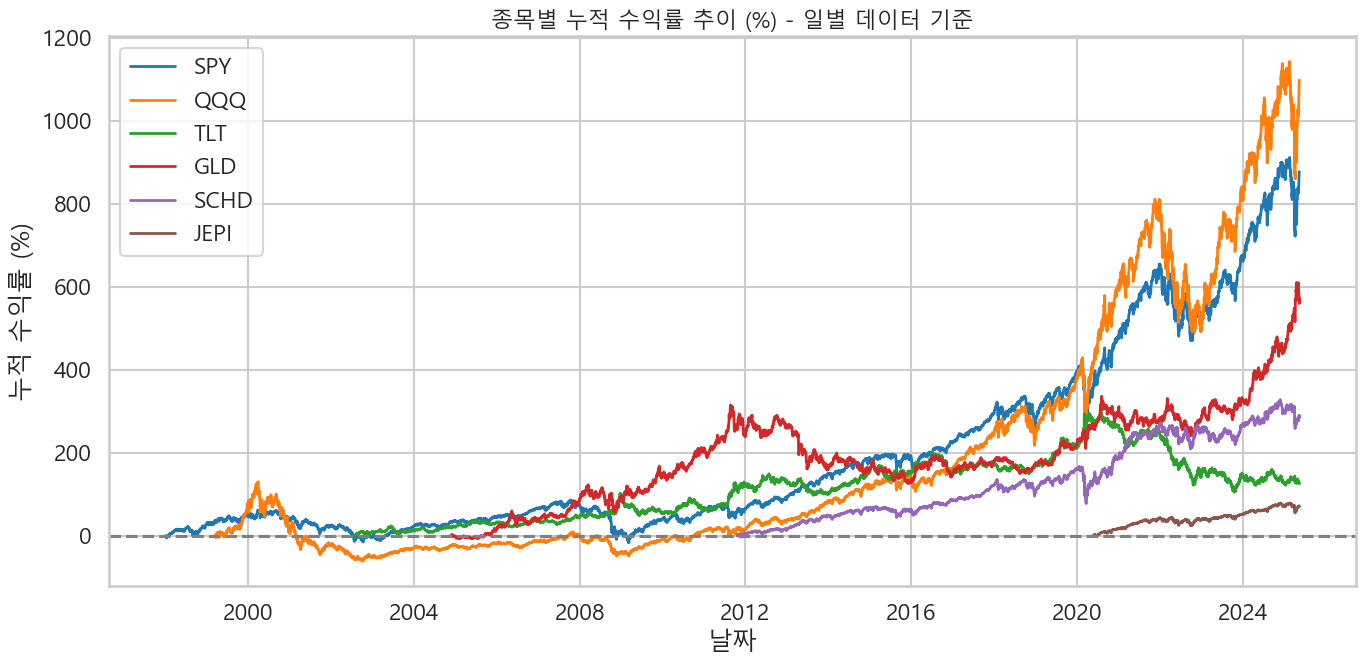

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 종목 목록과 파일명 매핑
files = {
    "SPY": "./data_raw/SPY_OHLCV.csv",
    "QQQ": "./data_raw/QQQ_OHLCV.csv",
    "TLT": "./data_raw/TLT_OHLCV.csv",
    "GLD": "./data_raw/GLD_OHLCV.csv",
    "SCHD": "./data_raw/SCHD_OHLCV.csv",
    "JEPI": "./data_raw/JEPI_OHLCV.csv"
}

# 누적 수익률 저장용 데이터프레임
price_df = pd.DataFrame()

for symbol, filename in files.items():
    try:
        df = pd.read_csv(filename, parse_dates=['Date'])
        df = df.sort_values('Date')

        # 숫자형으로 변환
        df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
        df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

        # NaN 제거
        df = df.dropna(subset=['Open', 'Close'])

        # 기준가
        base_price = df.iloc[0]['Open']

        # 누적 수익률 계산
        df[f'{symbol}_누적수익률(%)'] = (df['Close'] - base_price) / base_price * 100

        # 날짜와 누적 수익률만 추출
        df = df[['Date', f'{symbol}_누적수익률(%)']]

        if price_df.empty:
            price_df = df
        else:
            price_df = pd.merge(price_df, df, on='Date', how='outer')

    except FileNotFoundError:
        print(f"⚠️ 파일 없음: {filename}, 이 종목은 제외됩니다.")

# 날짜 정렬
price_df = price_df.sort_values('Date')

# 시각화
plt.figure(figsize=(14, 7))
for col in price_df.columns:
    if "누적수익률" in col:
        plt.plot(price_df['Date'], price_df[col], label=col.replace("_누적수익률(%)", ""), linewidth=2)

plt.axhline(0, color='gray', linestyle='--')
plt.title("종목별 누적 수익률 추이 (%) - 일별 데이터 기준", fontsize=16)
plt.xlabel("날짜")
plt.ylabel("누적 수익률 (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

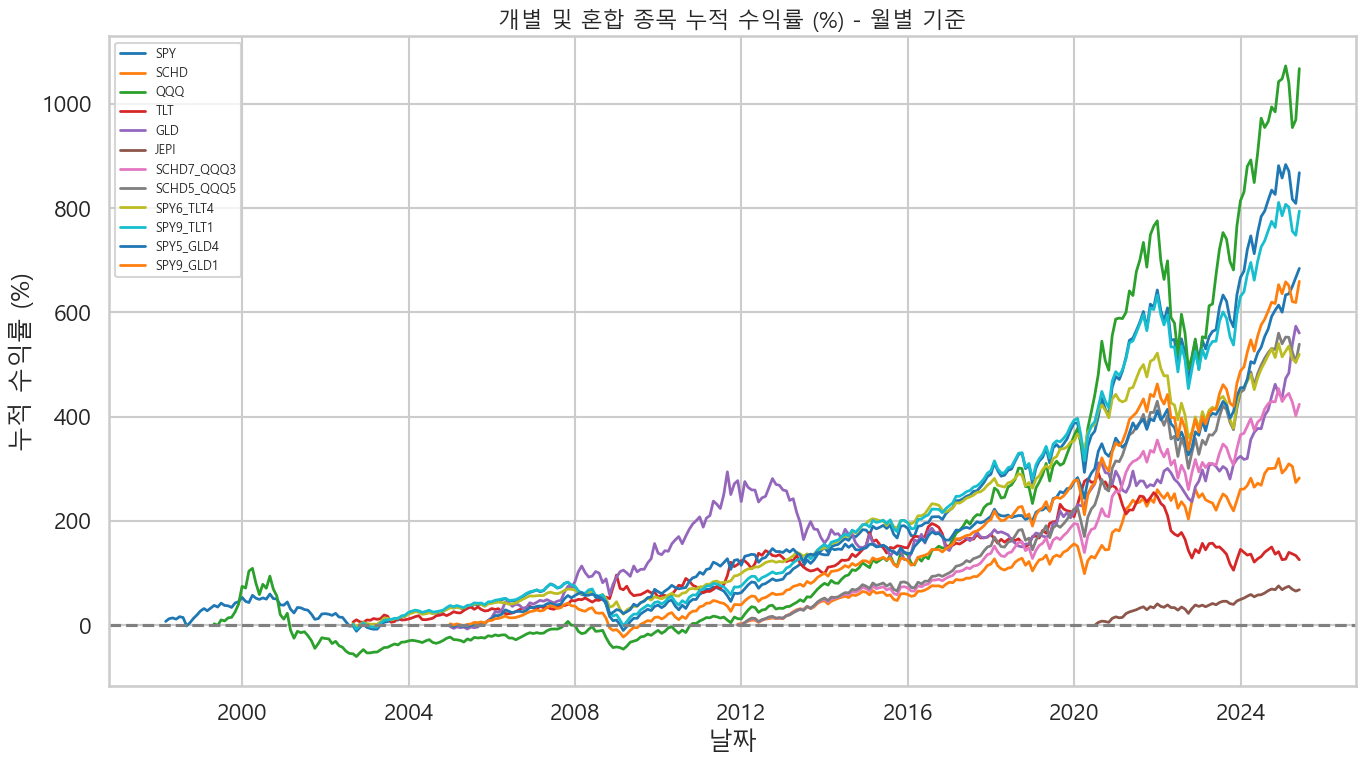

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# <1>의 개별 종목 + 혼합 종목
tickers = ['SPY', 'SCHD', 'QQQ', 'TLT', 'GLD', 'JEPI']

mixed_tickers = {
    'SCHD7_QQQ3': {'SCHD':0.7, 'QQQ':0.3},
    'SCHD5_QQQ5': {'SCHD':0.5, 'QQQ':0.5},
    'SPY6_TLT4': {'SPY':0.6, 'TLT':0.4},
    'SPY9_TLT1': {'SPY':0.9, 'TLT':0.1},
    'SPY5_GLD4': {'SPY':0.5, 'GLD':0.5},
    'SPY9_GLD1': {'SPY':0.9, 'GLD':0.1}
}

# 데이터 경로 및 월별 수익률 데이터 로드 (이미 로드되었다고 가정하고 monthly_return_dfs 사용)
# monthly_return_dfs 딕셔너리에 tickers 종목별 월별 수익률이 'Monthly Return' 컬럼으로 존재한다고 가정.

# 혼합 종목 월별 수익률 계산 함수
def calc_mixed_monthly_return(weights_dict, monthly_return_dfs):
    # 월별 날짜 인덱스 기준으로 통합 인덱스 생성 (SPY 기준)
    date_index = monthly_return_dfs['SPY'].index

    df = pd.DataFrame(index=date_index)

    for name, weights in weights_dict.items():
        ret = pd.Series(0, index=date_index, dtype=float)
        for t, w in weights.items():
            ret += monthly_return_dfs[t]['Monthly Return'] * w
        df[name] = ret

    return df

# 개별 종목 월별 수익률 DataFrame (tickers)
indiv_returns_df = pd.DataFrame({t: monthly_return_dfs[t]['Monthly Return'] for t in tickers})

# 혼합 종목 월별 수익률 계산
mixed_returns_df = calc_mixed_monthly_return(mixed_tickers, monthly_return_dfs)

# 전체 종목 월별 수익률 합치기
all_returns_df = pd.concat([indiv_returns_df, mixed_returns_df], axis=1)

# 누적 수익률 계산 (월별 수익률 누적 곱)
cumulative_returns_df = (1 + all_returns_df).cumprod() - 1
cumulative_returns_df *= 100  # % 단위로 변환

# 시각화
plt.figure(figsize=(14, 8))
for col in cumulative_returns_df.columns:
    plt.plot(cumulative_returns_df.index, cumulative_returns_df[col], label=col, linewidth=2)

plt.axhline(0, color='gray', linestyle='--')
plt.title('개별 및 혼합 종목 누적 수익률 (%) - 월별 기준', fontsize=16)
plt.xlabel('날짜')
plt.ylabel('누적 수익률 (%)')
plt.legend(loc='upper left', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

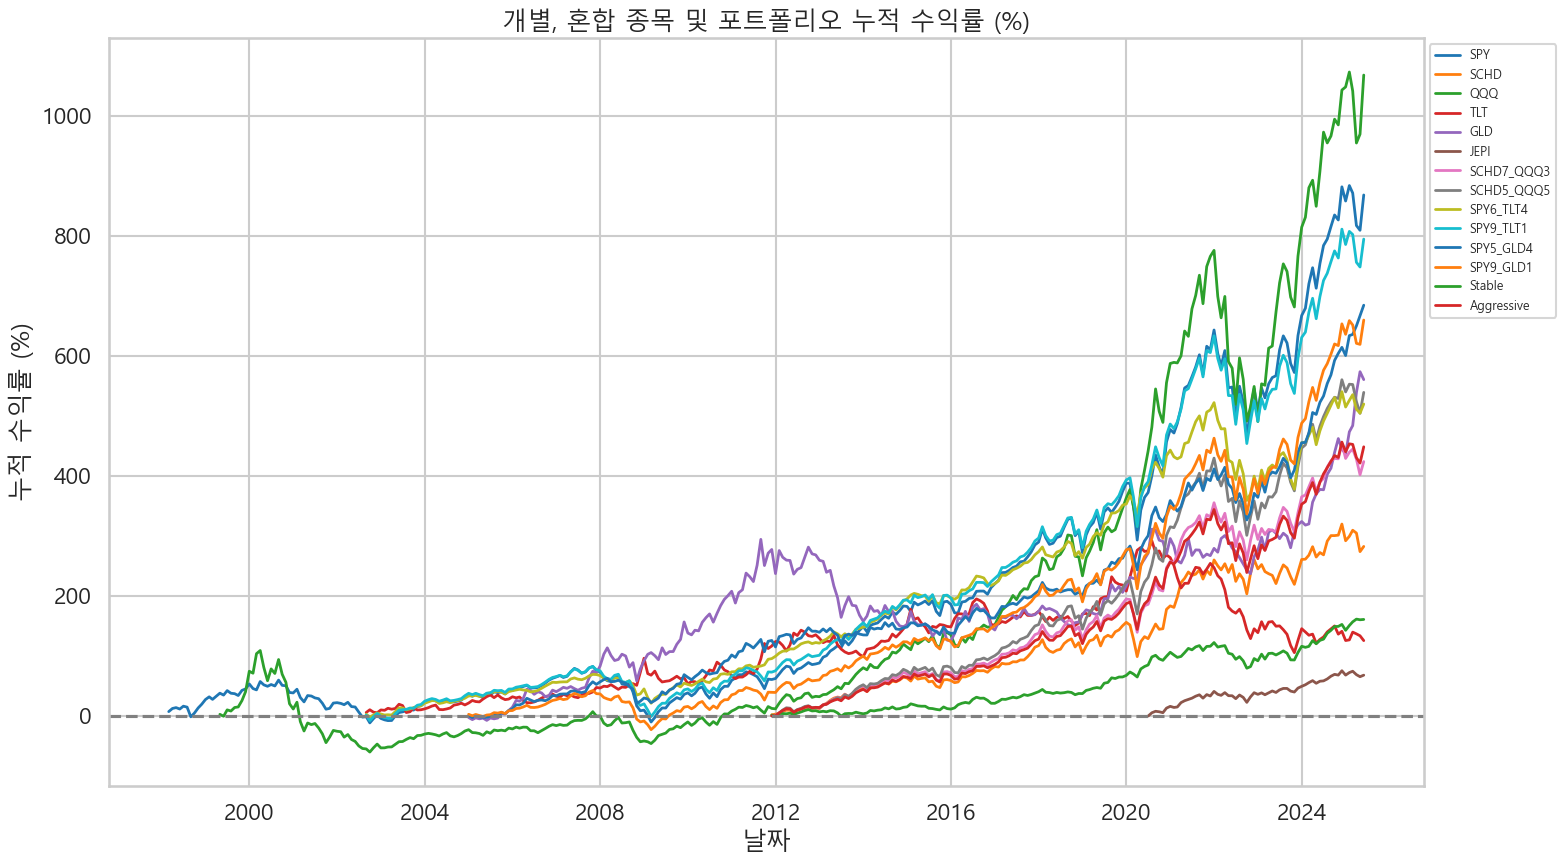

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# tickers, mixed_tickers, monthly_return_dfs는 이미 있다고 가정

# <혼합 종목 월별 수익률 계산 함수> (이미 주신 코드)
def calc_mixed_monthly_return(weights_dict, monthly_return_dfs):
    date_index = monthly_return_dfs['SPY'].index
    df = pd.DataFrame(index=date_index)
    for name, weights in weights_dict.items():
        ret = pd.Series(0, index=date_index, dtype=float)
        for t, w in weights.items():
            ret += monthly_return_dfs[t]['Monthly Return'] * w
        df[name] = ret
    return df

# 개별 종목 월별 수익률 DataFrame
indiv_returns_df = pd.DataFrame({t: monthly_return_dfs[t]['Monthly Return'] for t in tickers})

# 혼합 종목 월별 수익률 계산
mixed_returns_df = calc_mixed_monthly_return(mixed_tickers, monthly_return_dfs)

# 전체 개별 + 혼합 종목 월별 수익률
all_returns_df = pd.concat([indiv_returns_df, mixed_returns_df], axis=1)

# --- 여기에 portfolios 정의 ---
portfolios = {
    'Stable': {'SPY': 0, 'SCHD': 0.28, 'QQQ': 0.12, 'TLT': 0.25, 'GLD': 0.35},
    'Aggressive': {'SPY': 0.4, 'SCHD': 0.25, 'QQQ': 0.25, 'TLT': 0.05, 'GLD': 0.05}
}

# 포트폴리오 월별 수익률 계산
portfolio_returns = pd.DataFrame(index=all_returns_df.index)
for p_name, weights in portfolios.items():
    ret = pd.Series(0, index=all_returns_df.index, dtype=float)
    for ticker, w in weights.items():
        ret += all_returns_df[ticker] * w
    portfolio_returns[p_name] = ret

# 개별 + 혼합 + 포트폴리오 합치기
final_returns_df = pd.concat([all_returns_df, portfolio_returns], axis=1)

# 누적 수익률 계산
cumulative_returns_df = (1 + final_returns_df).cumprod() - 1
cumulative_returns_df *= 100  # %

# 그래프 그리기
plt.figure(figsize=(16, 9))
for col in cumulative_returns_df.columns:
    plt.plot(cumulative_returns_df.index, cumulative_returns_df[col], label=col, linewidth=2)

plt.axhline(0, color='gray', linestyle='--')
plt.title('개별, 혼합 종목 및 포트폴리오 누적 수익률 (%)', fontsize=18)
plt.xlabel('날짜')
plt.ylabel('누적 수익률 (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

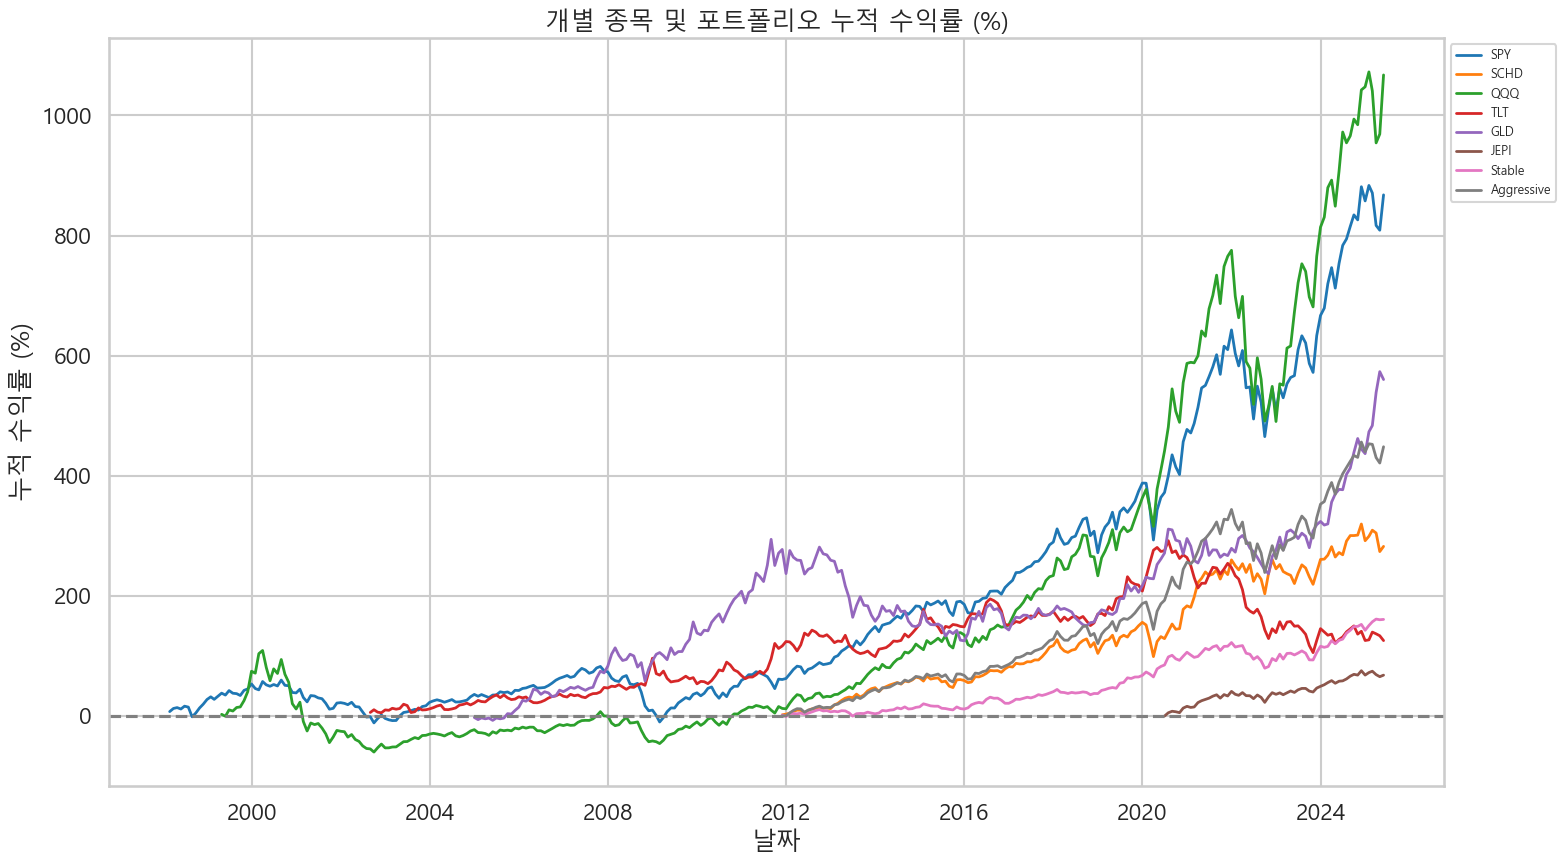

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 개별 종목 수익률 DataFrame
indiv_returns_df = pd.DataFrame({t: monthly_return_dfs[t]['Monthly Return'] for t in tickers})

# 포트폴리오 정의
# portfolios = {
#     'Stable': {'SPY': 0, 'SCHD': 0.28, 'QQQ': 0.12, 'TLT': 0.25, 'GLD': 0.35},
#     'Aggressive': {'SPY': 0.4, 'SCHD': 0.25, 'QQQ': 0.25, 'TLT': 0.05, 'GLD': 0.05}
# }

# 포트폴리오 수익률 계산
portfolio_returns = pd.DataFrame(index=indiv_returns_df.index)
for name, weights in portfolios.items():
    ret = pd.Series(0, index=indiv_returns_df.index, dtype=float)
    for ticker, w in weights.items():
        ret += indiv_returns_df[ticker] * w
    portfolio_returns[name] = ret

# 개별 + 포트폴리오 합치기
final_returns_df = pd.concat([indiv_returns_df, portfolio_returns], axis=1)

# 누적 수익률 계산
cumulative_returns_df = (1 + final_returns_df).cumprod() - 1
cumulative_returns_df *= 100  # %

# 시각화
plt.figure(figsize=(16, 9))
for col in cumulative_returns_df.columns:
    plt.plot(cumulative_returns_df.index, cumulative_returns_df[col], label=col, linewidth=2)

plt.axhline(0, color='gray', linestyle='--')
plt.title('개별 종목 및 포트폴리오 누적 수익률 (%)', fontsize=18)
plt.xlabel('날짜')
plt.ylabel('누적 수익률 (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

## 3-2. 포트폴리오/종목별 주가 선 그래프 (기준 시점 100으로 Normalize)

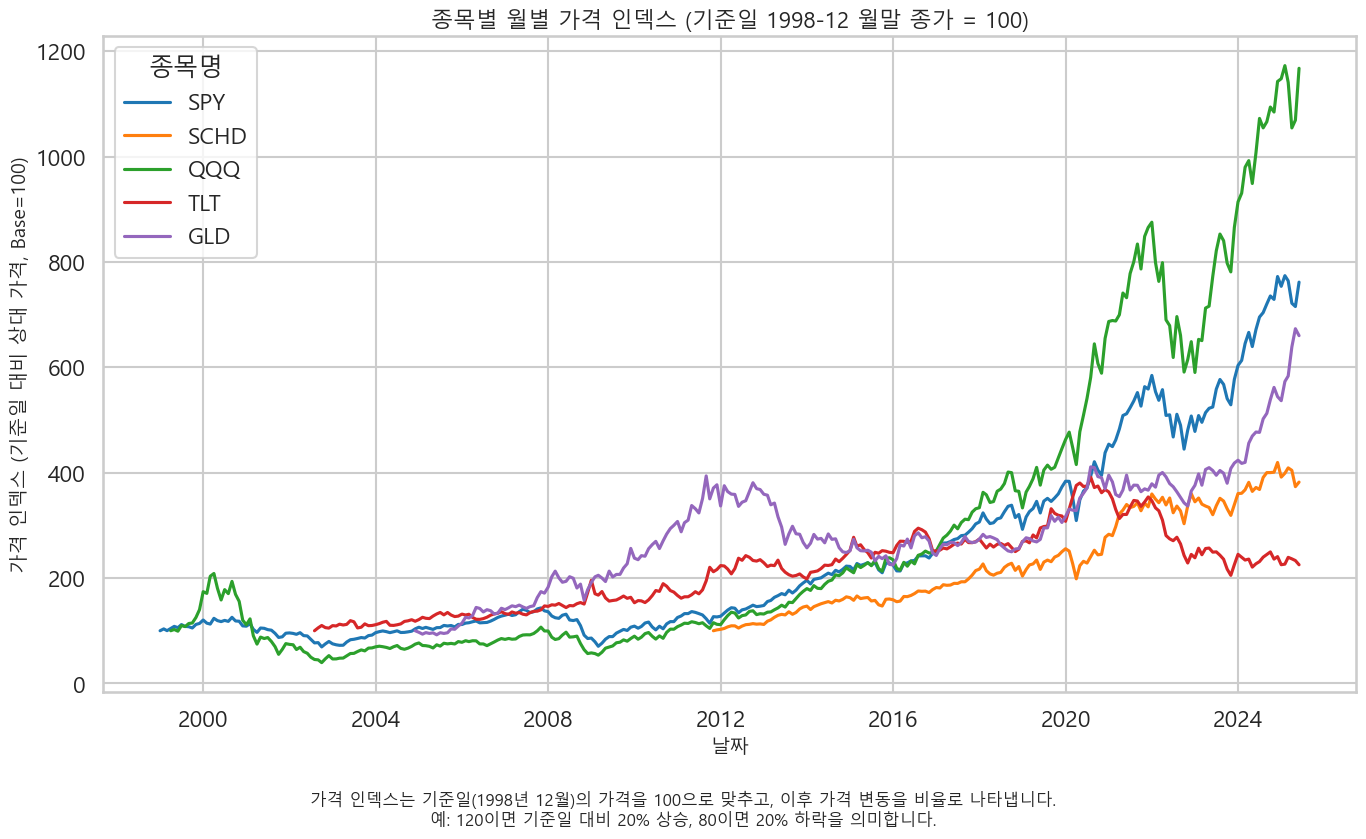

In [11]:
def plot_price_index(monthly_close_dfs, tickers, start_date='1998-12-01'):
    plt.figure(figsize=(14,8))
    for t in tickers:
        df = monthly_close_dfs[t]
        # start_date 이후 데이터만 사용
        df = df.loc[df.index >= start_date]
        # 기준일의 월말 종가를 100으로 맞춤 (가격 인덱스)
        base_price = df.iloc[0]['Monthly Close']
        price_index = df['Monthly Close'] / base_price * 100
        plt.plot(price_index.index, price_index, label=t)

    plt.title("종목별 월별 가격 인덱스 (기준일 1998-12 월말 종가 = 100)", fontsize=16)
    plt.xlabel("날짜", fontsize=14)
    plt.ylabel("가격 인덱스 (기준일 대비 상대 가격, Base=100)", fontsize=14)
    plt.legend(title="종목명")
    plt.grid(True)

    # 그래프 아래 간단한 설명 추가 (여백 확보 후 텍스트)
    plt.figtext(0.5, -0.05,
                "가격 인덱스는 기준일(1998년 12월)의 가격을 100으로 맞추고, 이후 가격 변동을 비율로 나타냅니다.\n"
                "예: 120이면 기준일 대비 20% 상승, 80이면 20% 하락을 의미합니다.",
                ha="center", fontsize=12, wrap=True)

    plt.tight_layout()
    plt.show()

# 개별 종목만
plot_price_index(monthly_close_dfs, tickers=['SPY', 'SCHD', 'QQQ', 'TLT', 'GLD'])

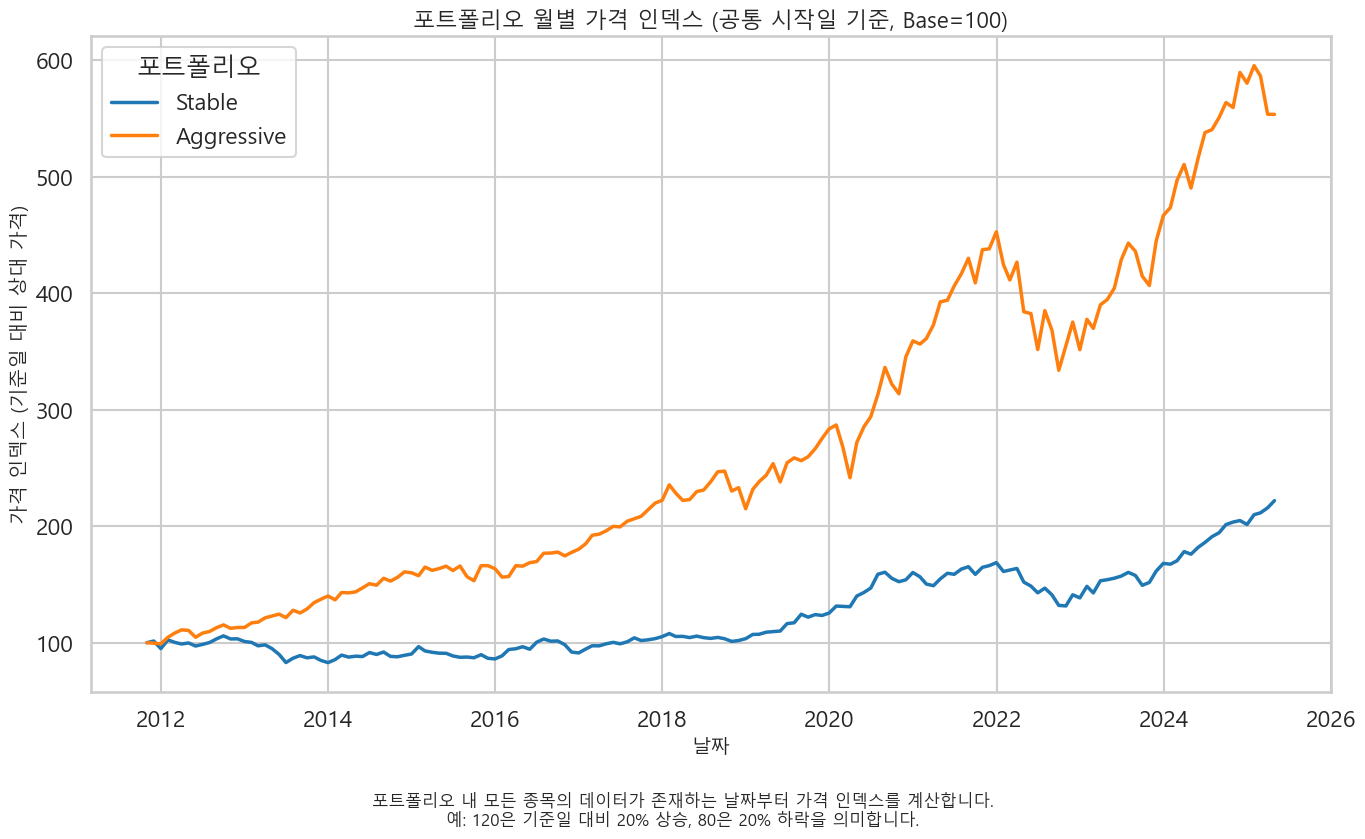

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_portfolio_price_index_only(monthly_close_dfs, portfolios):
    plt.figure(figsize=(14, 8))

    for pname, weights in portfolios.items():
        # 공통 인덱스를 잡기 위해 가장 늦게 시작한 종목의 시작일 찾기
        start_dates = []
        for t in weights:
            if t in monthly_close_dfs and weights[t] > 0:
                start_dates.append(monthly_close_dfs[t].dropna().index[0])
        if not start_dates:
            continue
        # 포트폴리오 내 모든 종목의 시작일 중 가장 늦은 날로 시작일 설정
        common_start = max(start_dates)

        # 포트폴리오 종가 계산
        common_index = pd.date_range(start=common_start, end=pd.Timestamp.today(), freq='ME')
        portfolio_price = pd.Series(0.0, index=common_index)

        for t, w in weights.items():
            if t not in monthly_close_dfs or w == 0:
                continue
            temp_df = monthly_close_dfs[t].copy()
            temp_df = temp_df[temp_df.index >= common_start]
            temp_close = temp_df['Monthly Close'].reindex(common_index).ffill()
            portfolio_price += temp_close * w

        portfolio_price = portfolio_price.dropna()
        if portfolio_price.empty:
            continue

        base_price = portfolio_price.iloc[0]
        price_index = portfolio_price / base_price * 100
        plt.plot(price_index.index, price_index, label=pname, linewidth=2.5)

    plt.title("포트폴리오 월별 가격 인덱스 (공통 시작일 기준, Base=100)", fontsize=16)
    plt.xlabel("날짜", fontsize=14)
    plt.ylabel("가격 인덱스 (기준일 대비 상대 가격)", fontsize=14)
    plt.legend(title="포트폴리오", loc='best')
    plt.grid(True)

    plt.figtext(0.5, -0.05,
                "포트폴리오 내 모든 종목의 데이터가 존재하는 날짜부터 가격 인덱스를 계산합니다.\n"
                "예: 120은 기준일 대비 20% 상승, 80은 20% 하락을 의미합니다.",
                ha="center", fontsize=12, wrap=True)

    plt.tight_layout()
    plt.show()

plot_portfolio_price_index_only(
    monthly_close_dfs,
    portfolios={
        'Stable': {'SPY': 0, 'SCHD': 0.28, 'QQQ': 0.12, 'TLT': 0.25, 'GLD': 0.35},
        'Aggressive': {'SPY': 0.4, 'SCHD': 0.25, 'QQQ': 0.25, 'TLT': 0.05, 'GLD': 0.05}
    }
)

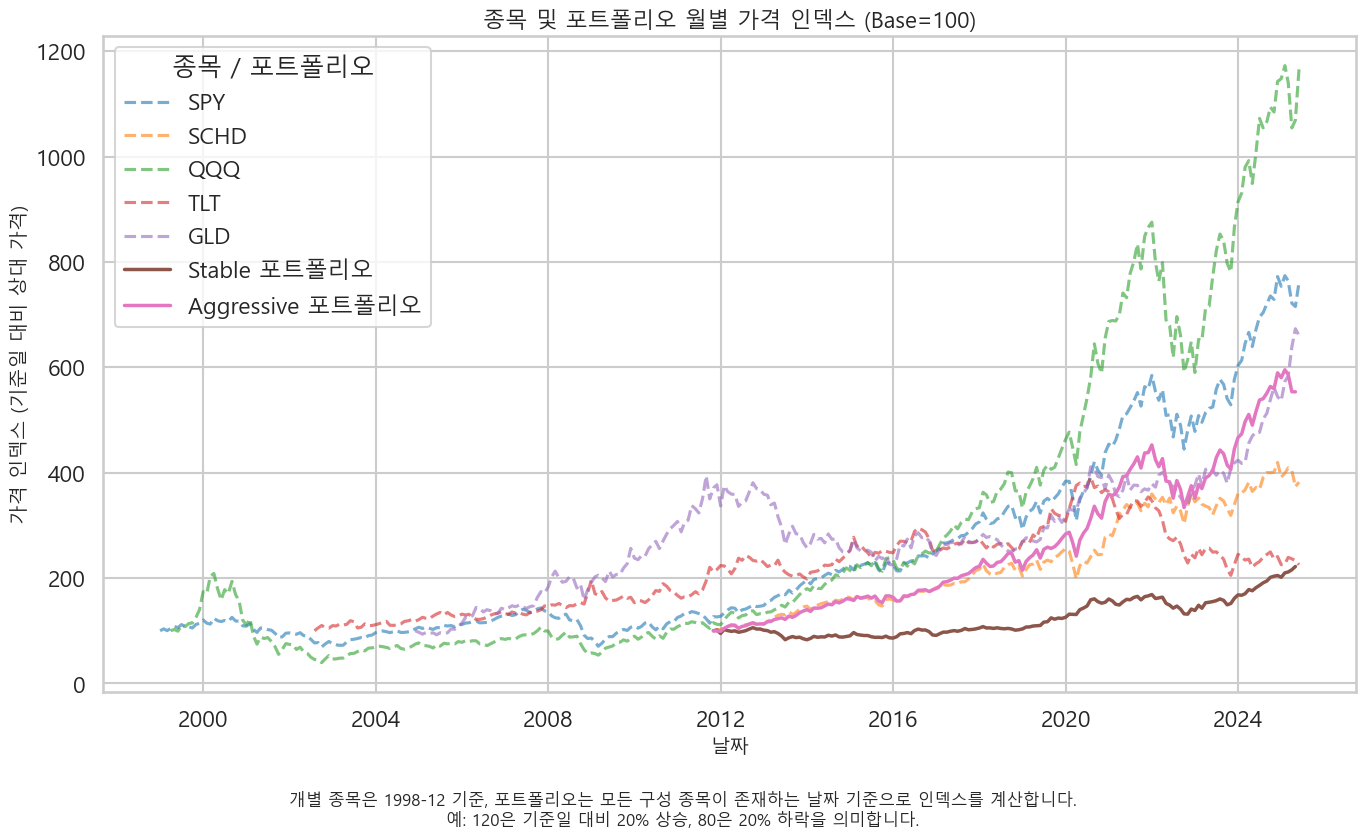

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_combined_price_index(monthly_close_dfs, portfolios, tickers, start_date='1998-12-01'):
    plt.figure(figsize=(14, 8))

    # 1. 개별 종목 인덱스
    for t in tickers:
        if t not in monthly_close_dfs:
            continue
        df = monthly_close_dfs[t].copy()
        df = df.loc[df.index >= start_date]
        if df.empty:
            continue
        base_price = df.iloc[0]['Monthly Close']
        price_index = df['Monthly Close'] / base_price * 100
        plt.plot(price_index.index, price_index, label=f"{t}", linestyle='--', alpha=0.6)

    # 2. 포트폴리오 인덱스
    for pname, weights in portfolios.items():
        # 공통 시작일 계산
        start_dates = []
        for t in weights:
            if t in monthly_close_dfs and weights[t] > 0:
                start_dates.append(monthly_close_dfs[t].dropna().index[0])
        if not start_dates:
            continue
        common_start = max(start_dates)

        common_index = pd.date_range(start=common_start, end=pd.Timestamp.today(), freq='ME')
        portfolio_price = pd.Series(0.0, index=common_index)

        for t, w in weights.items():
            if t not in monthly_close_dfs or w == 0:
                continue
            temp_df = monthly_close_dfs[t].copy()
            temp_df = temp_df[temp_df.index >= common_start]
            temp_close = temp_df['Monthly Close'].reindex(common_index).ffill()
            portfolio_price += temp_close * w

        portfolio_price = portfolio_price.dropna()
        if portfolio_price.empty:
            continue

        base_price = portfolio_price.iloc[0]
        price_index = portfolio_price / base_price * 100
        plt.plot(price_index.index, price_index, label=f"{pname} 포트폴리오", linewidth=2.5)

    # 전체 그래프 설정
    plt.title("종목 및 포트폴리오 월별 가격 인덱스 (Base=100)", fontsize=16)
    plt.xlabel("날짜", fontsize=14)
    plt.ylabel("가격 인덱스 (기준일 대비 상대 가격)", fontsize=14)
    plt.legend(title="종목 / 포트폴리오", loc='best')
    plt.grid(True)

    plt.figtext(0.5, -0.05,
                "개별 종목은 1998-12 기준, 포트폴리오는 모든 구성 종목이 존재하는 날짜 기준으로 인덱스를 계산합니다.\n"
                "예: 120은 기준일 대비 20% 상승, 80은 20% 하락을 의미합니다.",
                ha="center", fontsize=12, wrap=True)

    plt.tight_layout()
    plt.show()

plot_combined_price_index(
    monthly_close_dfs,
    portfolios={
        'Stable': {'SPY': 0, 'SCHD': 0.28, 'QQQ': 0.12, 'TLT': 0.25, 'GLD': 0.35},
        'Aggressive': {'SPY': 0.4, 'SCHD': 0.25, 'QQQ': 0.25, 'TLT': 0.05, 'GLD': 0.05}
    },
    tickers=['SPY', 'SCHD', 'QQQ', 'TLT', 'GLD']
)

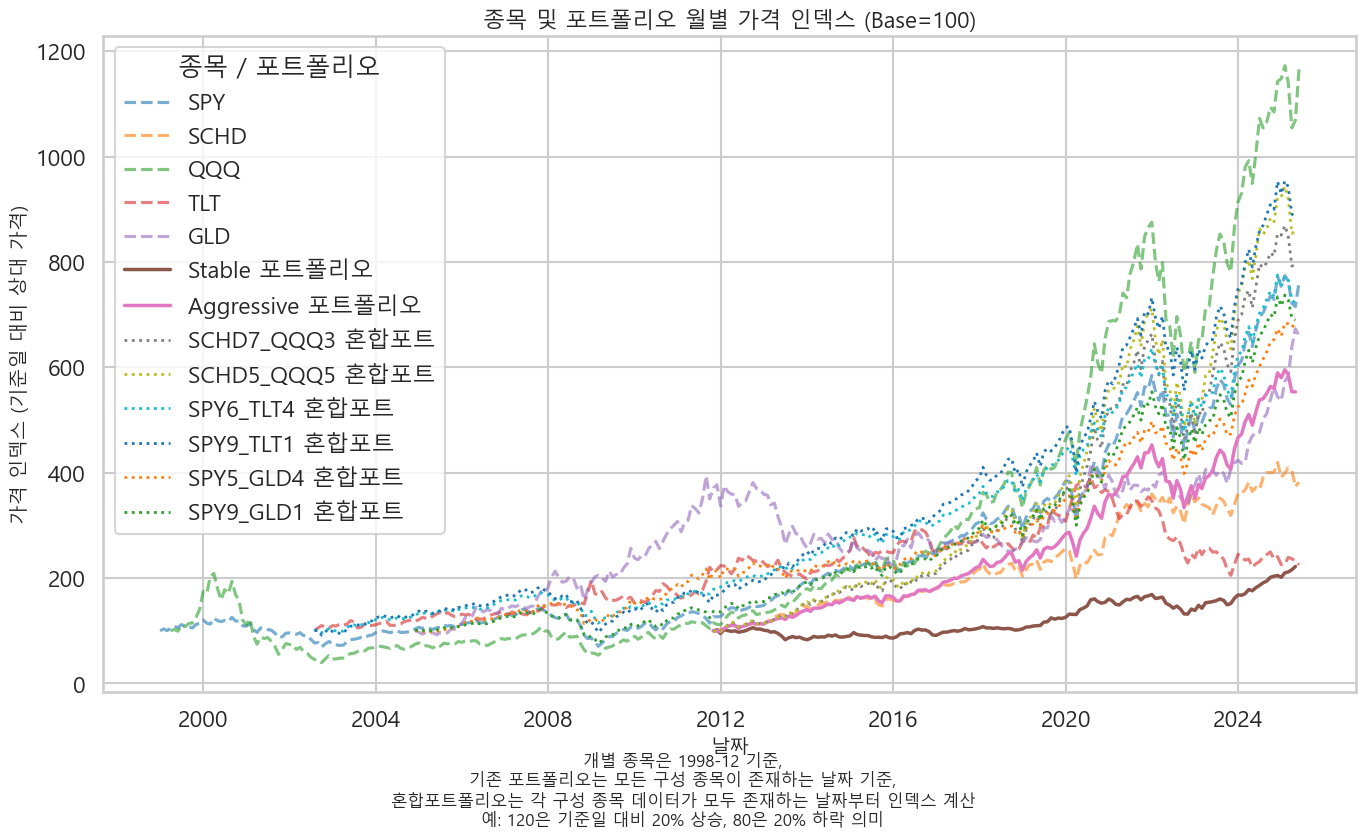

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_combined_price_index_with_mixed(
    monthly_close_dfs,
    portfolios,
    mixed_tickers,
    tickers,
    start_date='1998-12-01'
):
    plt.figure(figsize=(14, 8))

    # 1. 개별 종목 인덱스
    for t in tickers:
        if t not in monthly_close_dfs:
            continue
        df = monthly_close_dfs[t].copy()
        df = df.loc[df.index >= start_date]
        if df.empty:
            continue
        base_price = df.iloc[0]['Monthly Close']
        price_index = df['Monthly Close'] / base_price * 100
        plt.plot(price_index.index, price_index, label=f"{t}", linestyle='--', alpha=0.6)

    # 2. 기존 포트폴리오 인덱스
    for pname, weights in portfolios.items():
        start_dates = []
        for t in weights:
            if t in monthly_close_dfs and weights[t] > 0:
                start_dates.append(monthly_close_dfs[t].dropna().index[0])
        if not start_dates:
            continue
        common_start = max(start_dates)
        common_index = pd.date_range(start=common_start, end=pd.Timestamp.today(), freq='ME')
        portfolio_price = pd.Series(0.0, index=common_index)

        for t, w in weights.items():
            if t not in monthly_close_dfs or w == 0:
                continue
            temp_df = monthly_close_dfs[t].copy()
            temp_df = temp_df[temp_df.index >= common_start]
            temp_close = temp_df['Monthly Close'].reindex(common_index).ffill()
            portfolio_price += temp_close * w

        portfolio_price = portfolio_price.dropna()
        if portfolio_price.empty:
            continue

        base_price = portfolio_price.iloc[0]
        price_index = portfolio_price / base_price * 100
        plt.plot(price_index.index, price_index, label=f"{pname} 포트폴리오", linewidth=2.5)

    # 3. 혼합 포트폴리오 (mixed_tickers) 인덱스
    for mname, weights in mixed_tickers.items():
        start_dates = []
        for t in weights:
            if t in monthly_close_dfs and weights[t] > 0:
                start_dates.append(monthly_close_dfs[t].dropna().index[0])
        if not start_dates:
            continue
        common_start = max(start_dates)
        common_index = pd.date_range(start=common_start, end=pd.Timestamp.today(), freq='ME')
        portfolio_price = pd.Series(0.0, index=common_index)

        for t, w in weights.items():
            if t not in monthly_close_dfs or w == 0:
                continue
            temp_df = monthly_close_dfs[t].copy()
            temp_df = temp_df[temp_df.index >= common_start]
            temp_close = temp_df['Monthly Close'].reindex(common_index).ffill()
            portfolio_price += temp_close * w

        portfolio_price = portfolio_price.dropna()
        if portfolio_price.empty:
            continue

        base_price = portfolio_price.iloc[0]
        price_index = portfolio_price / base_price * 100
        plt.plot(price_index.index, price_index, label=f"{mname} 혼합포트", linewidth=2, linestyle=':')

    # 그래프 설정
    plt.title("종목 및 포트폴리오 월별 가격 인덱스 (Base=100)", fontsize=16)
    plt.xlabel("날짜", fontsize=14)
    plt.ylabel("가격 인덱스 (기준일 대비 상대 가격)", fontsize=14)
    plt.legend(title="종목 / 포트폴리오", loc='best')
    plt.grid(True)

    plt.figtext(0.5, -0.05,
                "개별 종목은 1998-12 기준,\n"
                "기존 포트폴리오는 모든 구성 종목이 존재하는 날짜 기준,\n"
                "혼합포트폴리오는 각 구성 종목 데이터가 모두 존재하는 날짜부터 인덱스 계산\n"
                "예: 120은 기준일 대비 20% 상승, 80은 20% 하락 의미",
                ha="center", fontsize=12, wrap=True)

    plt.tight_layout()
    plt.show()

# 예시 사용법
mixed_tickers = {
    'SCHD7_QQQ3': {'SCHD':0.7, 'QQQ':0.3},
    'SCHD5_QQQ5': {'SCHD':0.5, 'QQQ':0.5},
    'SPY6_TLT4': {'SPY':0.6, 'TLT':0.4},
    'SPY9_TLT1': {'SPY':0.9, 'TLT':0.1},
    'SPY5_GLD4': {'SPY':0.5, 'GLD':0.5},
    'SPY9_GLD1': {'SPY':0.9, 'GLD':0.1}
}

plot_combined_price_index_with_mixed(
    monthly_close_dfs,
    portfolios={
        'Stable': {'SPY': 0, 'SCHD': 0.28, 'QQQ': 0.12, 'TLT': 0.25, 'GLD': 0.35},
        'Aggressive': {'SPY': 0.4, 'SCHD': 0.25, 'QQQ': 0.25, 'TLT': 0.05, 'GLD': 0.05}
    },
    mixed_tickers=mixed_tickers,
    tickers=['SPY', 'SCHD', 'QQQ', 'TLT', 'GLD']
)

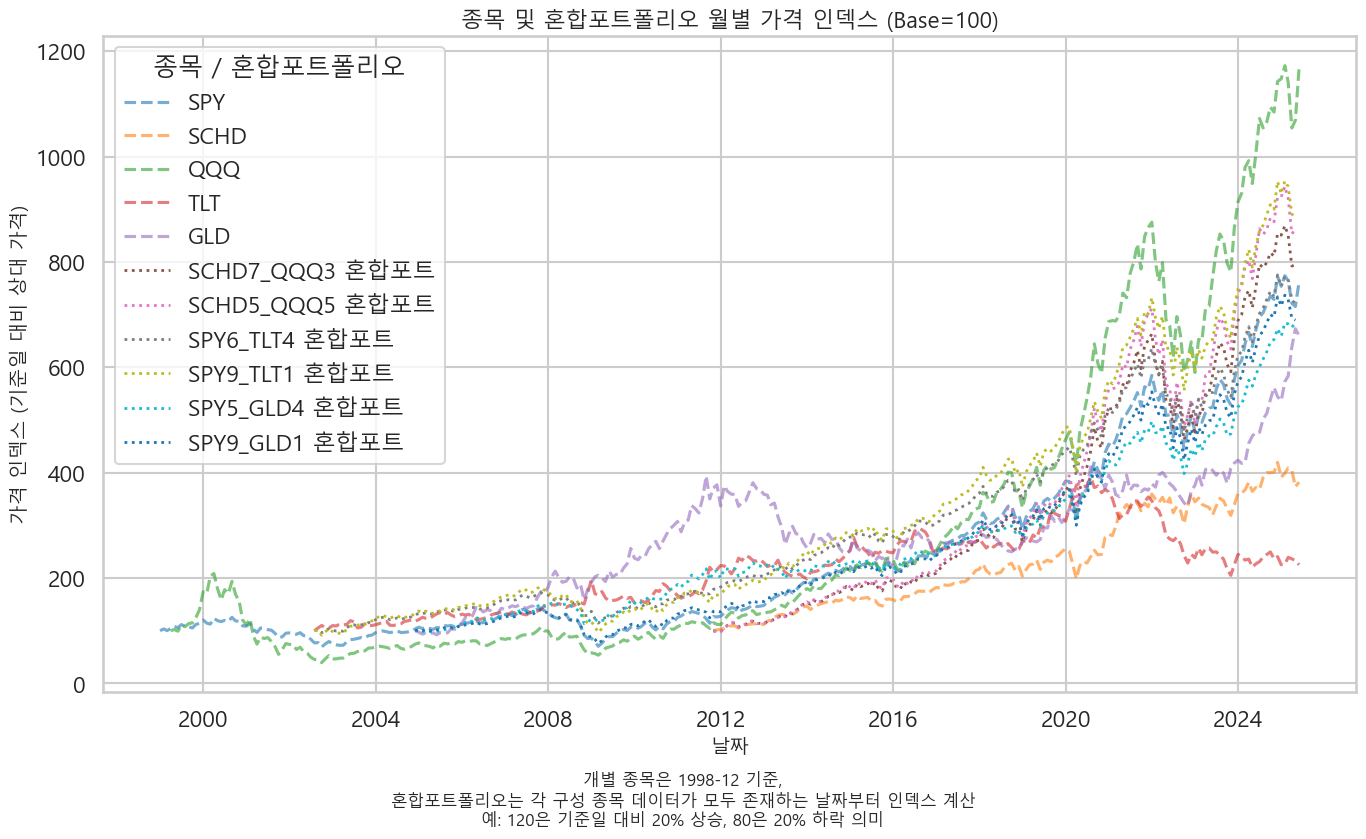

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_combined_price_index_with_mixed_no_portfolio(
    monthly_close_dfs,
    mixed_tickers,
    tickers,
    start_date='1998-12-01'
):
    plt.figure(figsize=(14, 8))

    # 1. 개별 종목 인덱스
    for t in tickers:
        if t not in monthly_close_dfs:
            continue
        df = monthly_close_dfs[t].copy()
        df = df.loc[df.index >= start_date]
        if df.empty:
            continue
        base_price = df.iloc[0]['Monthly Close']
        price_index = df['Monthly Close'] / base_price * 100
        plt.plot(price_index.index, price_index, label=f"{t}", linestyle='--', alpha=0.6)

    # 2. 혼합 포트폴리오 (mixed_tickers) 인덱스
    for mname, weights in mixed_tickers.items():
        start_dates = []
        for t in weights:
            if t in monthly_close_dfs and weights[t] > 0:
                start_dates.append(monthly_close_dfs[t].dropna().index[0])
        if not start_dates:
            continue
        common_start = max(start_dates)
        common_index = pd.date_range(start=common_start, end=pd.Timestamp.today(), freq='ME')
        portfolio_price = pd.Series(0.0, index=common_index)

        for t, w in weights.items():
            if t not in monthly_close_dfs or w == 0:
                continue
            temp_df = monthly_close_dfs[t].copy()
            temp_df = temp_df[temp_df.index >= common_start]
            temp_close = temp_df['Monthly Close'].reindex(common_index).ffill()
            portfolio_price += temp_close * w

        portfolio_price = portfolio_price.dropna()
        if portfolio_price.empty:
            continue

        base_price = portfolio_price.iloc[0]
        price_index = portfolio_price / base_price * 100
        plt.plot(price_index.index, price_index, label=f"{mname} 혼합포트", linewidth=2, linestyle=':')

    # 그래프 설정
    plt.title("종목 및 혼합포트폴리오 월별 가격 인덱스 (Base=100)", fontsize=16)
    plt.xlabel("날짜", fontsize=14)
    plt.ylabel("가격 인덱스 (기준일 대비 상대 가격)", fontsize=14)
    plt.legend(title="종목 / 혼합포트폴리오", loc='best')
    plt.grid(True)

    plt.figtext(0.5, -0.05,
                "개별 종목은 1998-12 기준,\n"
                "혼합포트폴리오는 각 구성 종목 데이터가 모두 존재하는 날짜부터 인덱스 계산\n"
                "예: 120은 기준일 대비 20% 상승, 80은 20% 하락 의미",
                ha="center", fontsize=12, wrap=True)

    plt.tight_layout()
    plt.show()

# 사용 예시
mixed_tickers = {
    'SCHD7_QQQ3': {'SCHD':0.7, 'QQQ':0.3},
    'SCHD5_QQQ5': {'SCHD':0.5, 'QQQ':0.5},
    'SPY6_TLT4': {'SPY':0.6, 'TLT':0.4},
    'SPY9_TLT1': {'SPY':0.9, 'TLT':0.1},
    'SPY5_GLD4': {'SPY':0.5, 'GLD':0.5},
    'SPY9_GLD1': {'SPY':0.9, 'GLD':0.1}
}

plot_combined_price_index_with_mixed_no_portfolio(
    monthly_close_dfs,
    mixed_tickers=mixed_tickers,
    tickers=['SPY', 'SCHD', 'QQQ', 'TLT', 'GLD']
)

## 3-3. 10년(=120개월) 롤링 수익률(복리 기준 연평균 수익률, CAGR)을 계산해서 그리는 그래프

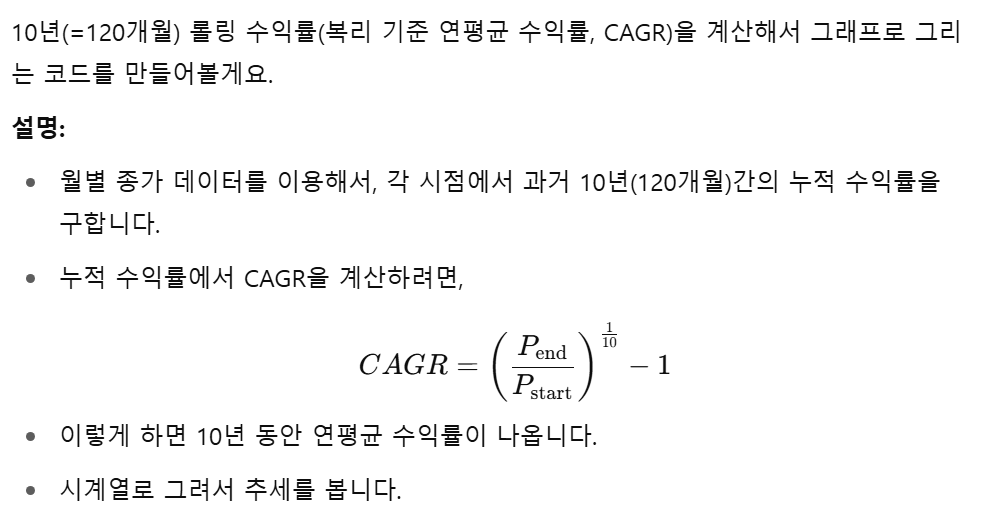

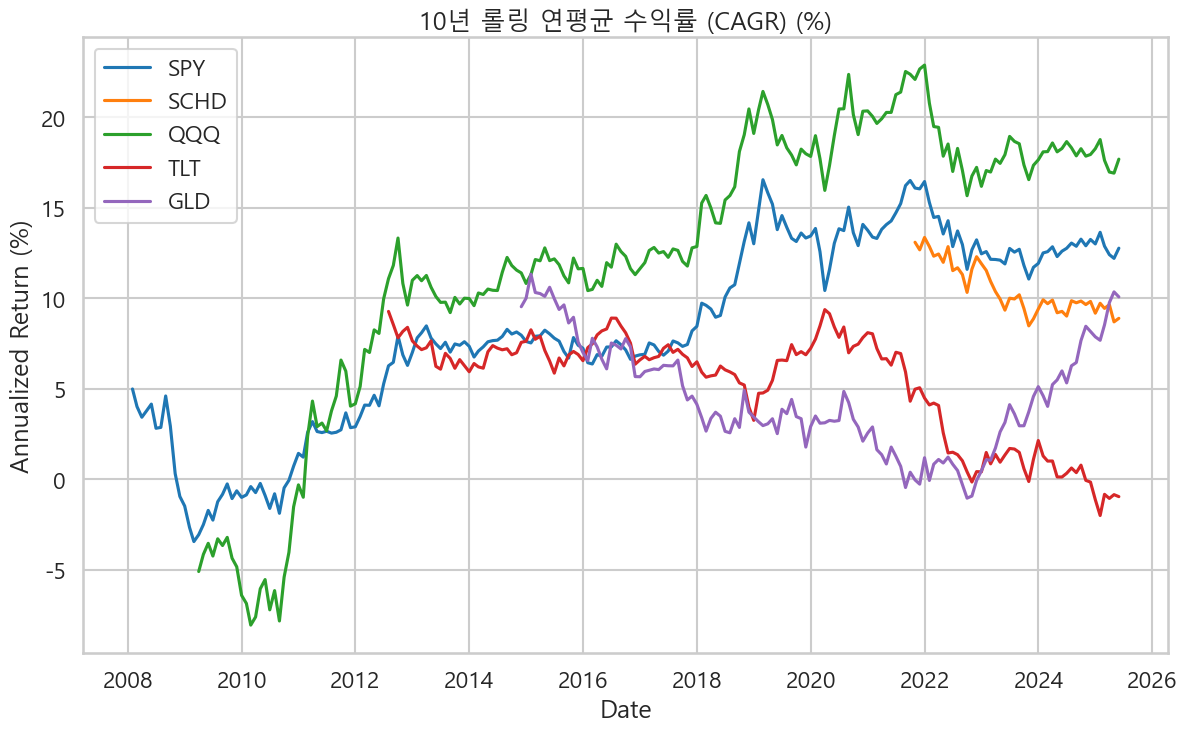

In [32]:
import matplotlib.pyplot as plt

def plot_10yr_rolling_return(monthly_close_dfs, tickers, window=120):  # 120개월 = 10년
    plt.figure(figsize=(14,8))

    for t in tickers:
        df = monthly_close_dfs[t]
        prices = df['Monthly Close']
        returns = []

        # window 기간 동안의 CAGR 계산
        for i in range(len(prices)):
            if i < window:
                returns.append(None)  # 10년 데이터 없으면 계산 불가
            else:
                start_price = prices.iloc[i-window]
                end_price = prices.iloc[i]
                cagr = (end_price / start_price)**(1/10) - 1
                returns.append(cagr * 100)  # %로 변환

        # 시리즈 생성 및 인덱스 맞추기
        rolling_return = pd.Series(returns, index=prices.index)

        plt.plot(rolling_return.index, rolling_return, label=t)

    plt.title("10년 롤링 연평균 수익률 (CAGR) (%)")
    plt.xlabel("Date")
    plt.ylabel("Annualized Return (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

# 사용 예시
plot_10yr_rolling_return(monthly_close_dfs, tickers=['SPY', 'SCHD', 'QQQ', 'TLT', 'GLD'])

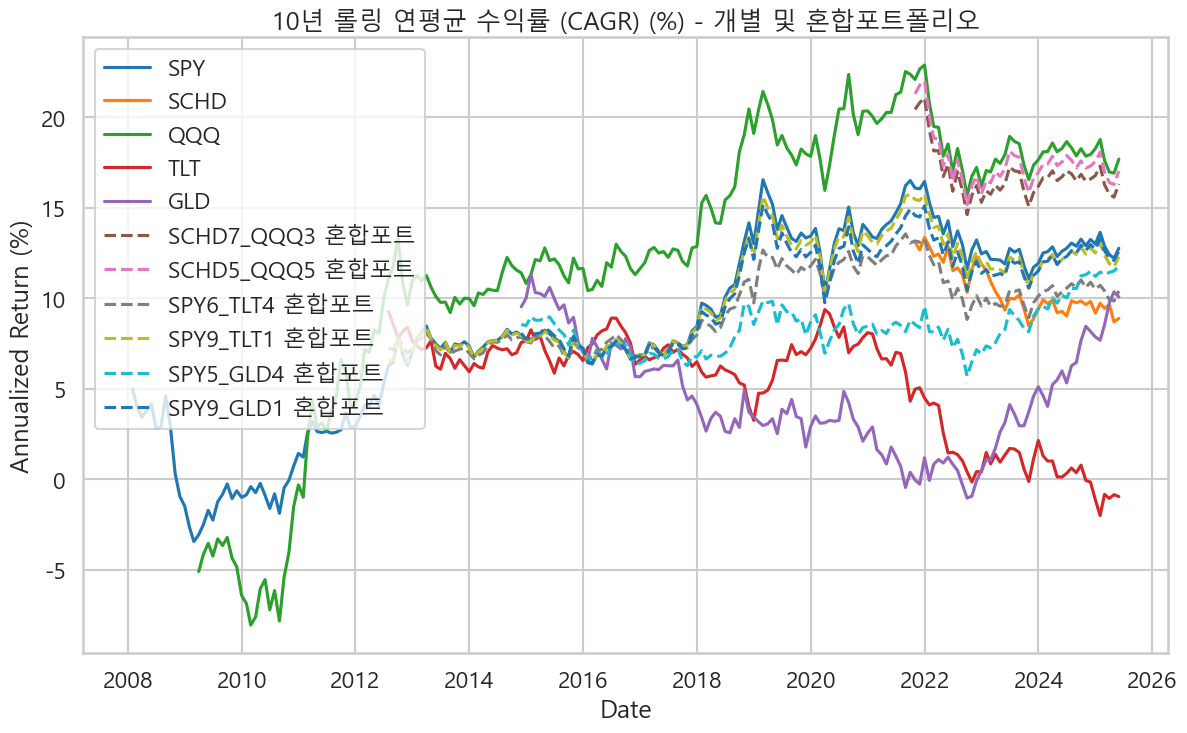

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_10yr_rolling_return_with_mixed(monthly_close_dfs, tickers, mixed_tickers, window=120):  # 120개월 = 10년
    plt.figure(figsize=(14,8))

    # 1. 개별 종목 10년 롤링 CAGR 계산 및 플롯
    for t in tickers:
        df = monthly_close_dfs[t]
        prices = df['Monthly Close']
        returns = []

        for i in range(len(prices)):
            if i < window:
                returns.append(None)
            else:
                start_price = prices.iloc[i-window]
                end_price = prices.iloc[i]
                cagr = (end_price / start_price)**(1/10) - 1
                returns.append(cagr * 100)  # %로 변환

        rolling_return = pd.Series(returns, index=prices.index)
        plt.plot(rolling_return.index, rolling_return, label=t)

    # 2. 혼합포트폴리오 10년 롤링 CAGR 계산 및 플롯
    for mname, weights in mixed_tickers.items():
        # 각 종목별 시작일 확인 후 가장 늦은 날짜부터 계산
        start_dates = []
        for t in weights:
            if t in monthly_close_dfs and weights[t] > 0:
                start_dates.append(monthly_close_dfs[t].dropna().index[0])
        if not start_dates:
            continue
        common_start = max(start_dates)

        # 공통 날짜 인덱스 설정 (window를 감안해 시작 지점 설정)
        end_date = monthly_close_dfs[next(iter(weights))].index[-1]  # 임의 종목의 마지막 날짜
        common_index = pd.date_range(start=common_start, end=end_date, freq='ME')

        # 혼합포트 가격 계산 (월별 가중평균 가격)
        portfolio_price = pd.Series(0.0, index=common_index)
        for t, w in weights.items():
            if t not in monthly_close_dfs or w == 0:
                continue
            temp_df = monthly_close_dfs[t]
            temp_close = temp_df['Monthly Close'].reindex(common_index).ffill()
            portfolio_price += temp_close * w

        # 10년 롤링 CAGR 계산
        returns = []
        prices = portfolio_price.dropna()
        for i in range(len(prices)):
            if i < window:
                returns.append(None)
            else:
                start_price = prices.iloc[i-window]
                end_price = prices.iloc[i]
                cagr = (end_price / start_price)**(1/10) - 1
                returns.append(cagr * 100)

        rolling_return = pd.Series(returns, index=prices.index)
        plt.plot(rolling_return.index, rolling_return, label=f"{mname} 혼합포트", linestyle='--')

    plt.title("10년 롤링 연평균 수익률 (CAGR) (%) - 개별 및 혼합포트폴리오")
    plt.xlabel("Date")
    plt.ylabel("Annualized Return (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

# 사용 예시
mixed_tickers = {
    'SCHD7_QQQ3': {'SCHD':0.7, 'QQQ':0.3},
    'SCHD5_QQQ5': {'SCHD':0.5, 'QQQ':0.5},
    'SPY6_TLT4': {'SPY':0.6, 'TLT':0.4},
    'SPY9_TLT1': {'SPY':0.9, 'TLT':0.1},
    'SPY5_GLD4': {'SPY':0.5, 'GLD':0.5},
    'SPY9_GLD1': {'SPY':0.9, 'GLD':0.1}
}

plot_10yr_rolling_return_with_mixed(
    monthly_close_dfs,
    tickers=['SPY', 'SCHD', 'QQQ', 'TLT', 'GLD'],
    mixed_tickers=mixed_tickers
)

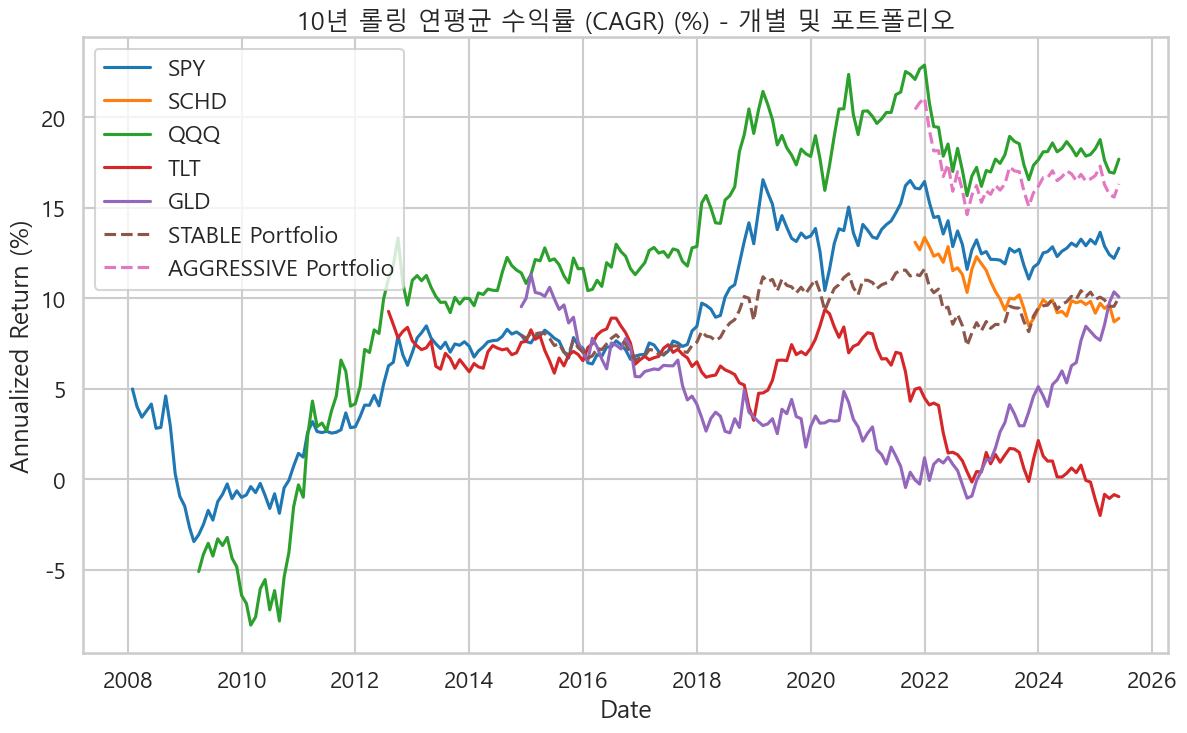

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_10yr_rolling_return_with_portfolios(monthly_close_dfs, tickers, portfolios, window=120):
    plt.figure(figsize=(14,8))

    # 1. 개별 종목 10년 롤링 CAGR 계산 및 플롯
    for t in tickers:
        df = monthly_close_dfs[t]
        prices = df['Monthly Close']
        returns = []

        for i in range(len(prices)):
            if i < window:
                returns.append(None)
            else:
                start_price = prices.iloc[i-window]
                end_price = prices.iloc[i]
                cagr = (end_price / start_price)**(1/10) - 1
                returns.append(cagr * 100)

        rolling_return = pd.Series(returns, index=prices.index)
        plt.plot(rolling_return.index, rolling_return, label=t)

    # 2. 포트폴리오별 가중평균 가격 계산 및 롤링 CAGR 계산, 플롯
    for pname, weights in portfolios.items():
        # 공통 인덱스 설정 (가장 늦은 시작일과 가장 이른 종료일 고려)
        start_dates = [monthly_close_dfs[t].dropna().index[0] for t in weights if t in monthly_close_dfs and weights[t] > 0]
        end_dates = [monthly_close_dfs[t].dropna().index[-1] for t in weights if t in monthly_close_dfs and weights[t] > 0]
        if not start_dates or not end_dates:
            continue
        common_start = max(start_dates)
        common_end = min(end_dates)
        common_index = pd.date_range(start=common_start, end=common_end, freq='ME')

        portfolio_price = pd.Series(0.0, index=common_index)
        for t, w in weights.items():
            if t not in monthly_close_dfs or w == 0:
                continue
            temp_df = monthly_close_dfs[t]
            temp_close = temp_df['Monthly Close'].reindex(common_index).ffill()
            portfolio_price += temp_close * w

        returns = []
        prices = portfolio_price.dropna()
        for i in range(len(prices)):
            if i < window:
                returns.append(None)
            else:
                start_price = prices.iloc[i-window]
                end_price = prices.iloc[i]
                cagr = (end_price / start_price)**(1/10) - 1
                returns.append(cagr * 100)

        rolling_return = pd.Series(returns, index=prices.index)
        plt.plot(rolling_return.index, rolling_return, label=f"{pname} Portfolio", linestyle='--')

    plt.title("10년 롤링 연평균 수익률 (CAGR) (%) - 개별 및 포트폴리오")
    plt.xlabel("Date")
    plt.ylabel("Annualized Return (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

# 포트폴리오 예시
PORTFOLIOS = {
    'STABLE': {'SPY': 0.5, 'TLT': 0.4, 'GLD': 0.1},
    'AGGRESSIVE': {'SCHD': 0.7, 'QQQ': 0.3}
}

# 호출 예시
plot_10yr_rolling_return_with_portfolios(
    monthly_close_dfs,
    tickers=['SPY', 'SCHD', 'QQQ', 'TLT', 'GLD'],
    portfolios=PORTFOLIOS
)